# Rover strategy

以下は、 Dugatkin, L. A., & Wilson, D. S. (1991). Rover: a strategy for exploiting cooperators in a patchy environment. The American Naturalist, 138(3), 687-701. の結果を簡易的に再現したものです。論文では解析モデルに基づく数値シミュレーションで結果が出されていますが、下記では同等の結果をマルチエージェントシミュレーションで再現しています。

# The Model

In [3]:
using Random
using Statistics: mean
using StatsBase: countmap
using Plots

using Test: @testset, @test

## 1. Strategies

In [5]:
@enum Action C D

STRATEGIES = Dict{Symbol, Function}(
    :TFT => (history::Vector{Action}) -> isempty(history) || history[end] == C ? C : D,
    :ROVER => (_) -> D,  # ROVER = movable ALWAYS_DEFECT
);

## 2. Agent

In [7]:
mutable struct Agent
    id::Int
    strategy_name::Symbol
    strategy_func::Function
    history::Dict{Int, Vector{Action}}
    payoff::Float64

    Agent(id::Int, strategy_name::Symbol) = new(id, strategy_name, STRATEGIES[strategy_name], Dict{Int64, Vector{Action}}(), 0.0)
    Agent(strategy_name::Symbol) = Agent(0, strategy_name)
end

function Base.show(io::IO, agent::Agent)::Nothing
    print(io, "id: $(agent.id),  strategy: $(agent.strategy_name), history: $(agent.history), payoff: $(agent.payoff)")
end;

In [8]:
@testset "Agent and strategy" begin
    tft_agent = Agent(:TFT)
    @test "$(tft_agent)" == "id: 0,  strategy: TFT, history: Dict{Int64, Vector{Action}}(), payoff: 0.0"
    @test tft_agent.strategy_func(Action[]) == C
    @test tft_agent.strategy_func([C, D]) == D
    @test tft_agent.strategy_func([D, C]) == C

    rover_agent = Agent(:ROVER)
    @test "$(rover_agent)" == "id: 0,  strategy: ROVER, history: Dict{Int64, Vector{Action}}(), payoff: 0.0"
    @test rover_agent.strategy_func(Action[]) == D
    @test rover_agent.strategy_func([C, D]) == D
    @test rover_agent.strategy_func([D, C]) == D
end;

Test Summary:      | Pass  Total  Time
Agent and strategy |    8      8  0.2s


## 3. Patch

In [10]:
mutable struct Patch
    id::Int
    agents::Vector{Agent}
end

function Patch(id::Int, patch_size::Int, tft_rate::Float64)::Patch
    mC = round(Int, patch_size * tft_rate)
    mD = patch_size - mC

    agents = [[Agent(id, :TFT) for id in 1:mC]; [Agent(id, :ROVER) for id in (mC + 1):(mC + mD)]]

    return Patch(id, agents)
end

function Patch(patch_size::Int, tft_rate::Float64)::Patch
    Patch(0, patch_size, tft_rate)
end

function calc_populations(patch::Patch)::Tuple{Int64, Int64}
    count_dict = countmap([a.strategy_name for a in patch.agents])

    return get(count_dict, :TFT, 0), get(count_dict, :ROVER, 0)
end

function calc_populations(patches::Vector{Patch})::Tuple{Int64, Int64}
    tft_pop, rvr_pop = (0, 0)

    for patch in patches
        pops = calc_populations(patch)
        tft_pop += pops[1]
        rvr_pop += pops[2]
    end

    return tft_pop, rvr_pop
end

function calc_average_payoffs(patch::Patch)::Tuple{Float64, Float64}
    tft_payoff = 0.0
    rvr_payoff = 0.0

    for agent in patch.agents
        if agent.strategy_name == :TFT
            tft_payoff += agent.payoff
        elseif agent.strategy_name == :ROVER
            rvr_payoff += agent.payoff
        end
    end

    tft_pop, rvr_pop = calc_populations(patch)

    return tft_pop == 0 ? 0 : tft_payoff / tft_pop, rvr_pop == 0 ? 0 : rvr_payoff / rvr_pop
end

calc_average_payoff(patch::Patch)::Float64 = mean([agent.payoff for agent in patch.agents]);

function make_agent_pair_vec(patch::Patch)::Vector{Tuple{Agent, Agent}}
    agent_count = length(patch.agents)
    agent_id_vec = shuffle(collect(1:agent_count))

    if agent_count % 2 != 0
        agent_id_vec = agent_id_vec[1:(end - 1)]
        agent_count -= 1
    end

    agent_pair_vec = [(patch.agents[agent_id_vec[i]], patch.agents[agent_id_vec[i+1]]) for i in 1:2:agent_count]

    return agent_pair_vec
end

function make_patches(;patch_num::Int = 10, patch_size::Int = 10, tft_rate::Float64 = 0.5)::Vector{Patch}
    return [Patch(id, patch_size, tft_rate) for id in 1:patch_num]
end;

In [11]:
@testset "Patch" begin
    patch = Patch(11, 0.4)
    @test calc_populations(patch) == (4, 7)
    @test [a.strategy_name for a in patch.agents] == [:TFT, :TFT, :TFT, :TFT, :ROVER, :ROVER, :ROVER, :ROVER, :ROVER, :ROVER, :ROVER]
end

@testset "make_agent_pair_vec" begin
    patch = Patch(11, 0.4)
    agent_pair_vec = make_agent_pair_vec(patch)

    println("# Confirm randomness")
    for agent_pair in agent_pair_vec
        @show [agent.id for agent in agent_pair]
    end
end

@testset "make_patches" begin
    patches = make_patches()

    for patch in patches
        @test [a.id for a in patch.agents] == [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        @test [a.strategy_name for a in patch.agents] == [:TFT, :TFT, :TFT, :TFT, :TFT, :ROVER, :ROVER, :ROVER, :ROVER, :ROVER]
    end
end;

Test Summary: | Pass  Total  Time
Patch         |    2      2  0.0s
# Confirm randomness
[agent.id for agent = agent_pair] = [5, 7]
[agent.id for agent = agent_pair] = [10, 2]
[agent.id for agent = agent_pair] = [6, 3]
[agent.id for agent = agent_pair] = [1, 11]
[agent.id for agent = agent_pair] = [4, 8]
Test Summary:       |Time
make_agent_pair_vec | None  0.1s
Test Summary: | Pass  Total  Time
make_patches  |   20     20  0.0s


## 4. Game

In [13]:
hist = Dict{Int, Vector{Action}}()
hist[5] = Action[]

Action[]

In [14]:
# const PAYOFF = (
#     R = 0.7,  # CC
#     T = 1.0,  # DC
#     S = 0.0,  # CD
#     P = 0.6   # DD
# )
const PAYOFF = (
    R = 3.0,  # CC
    T = 5.0,  # DC
    S = 0.0,  # CD
    P = 1.0   # DD
)

function play_game!(agent1::Agent, agent2::Agent)::Nothing
    agent2_history = get(agent1.history, agent2.id, Action[])
    agent1_history = get(agent2.history, agent1.id, Action[])

    action1 = agent1.strategy_func(agent2_history)
    action2 = agent2.strategy_func(agent1_history)

    payoff1, payoff2 = if (action1, action2) == (C, C)
        PAYOFF.R, PAYOFF.R
    elseif (action1, action2) == (D, C)
        PAYOFF.T, PAYOFF.S
    elseif (action1, action2) == (C, D)
        PAYOFF.S, PAYOFF.T
    elseif (action1, action2) == (D, D)
        PAYOFF.P, PAYOFF.P
    end

    agent1.payoff += payoff1
    agent2.payoff += payoff2

    # Agent1 learns agent2's action.
    if agent2.id ∈ keys(agent1.history)
        push!(agent1.history[agent2.id], action2)
    else
        agent1.history[agent2.id] = [action2]
    end

    # Agent2 learns agent1's action.
    if agent1.id ∈ keys(agent2.history)
        push!(agent2.history[agent1.id], action1)
    else
        agent2.history[agent1.id] = [action1]
    end

    return
end;

In [15]:
@testset "play_game!" begin
    agent1 = Agent(1, :TFT)
    agent2 = Agent(2, :ROVER)
    agent3 = Agent(3, :TFT)
    
    # 1st game: TFT vs. ROVER
    play_game!(agent1, agent2)
    @test agent1.history[2] == [D]
    @test agent1.payoff == PAYOFF.S
    @test agent2.history[1] == [C]
    @test agent2.payoff == PAYOFF.T

    # 2nd game: TFT vs. ROVER
    play_game!(agent1, agent2)
    @test agent1.history[2] == [D, D]
    @test agent1.payoff == PAYOFF.S + PAYOFF.P
    @test agent2.history[1] == [C, D]
    @test agent2.payoff == PAYOFF.T + PAYOFF.P

    # 1st game: TFT vs. TFT
    play_game!(agent1, agent3)
    @test agent1.history[2] == [D, D]
    @test agent1.history[3] == [C]
    @test agent1.payoff == PAYOFF.S + PAYOFF.P + PAYOFF.R
    @test agent3.history[1] == [C]
    @test agent3.payoff == PAYOFF.R
end;

Test Summary: | Pass  Total  Time
play_game!    |   13     13  0.0s


## 5. Migration

In [17]:
function migrate!(original_patch::Patch, destination_patch::Patch, agent::Agent)::Nothing
    # remove the agent from the origin patch
    filter!(a -> a.id != agent.id, original_patch.agents)

    # add the agent to the destination patch
    id_vec = [a.id for a in destination_patch.agents]
    max_id = isempty(id_vec) ? 0 : maximum(id_vec)
    agent.id = max_id + 1
    push!(destination_patch.agents, agent)

    return
end;

In [18]:
@testset "migrate!" begin
    patches = make_patches(patch_num = 3, patch_size = 5)
    migrate!(patches[1], patches[2], patches[1].agents[2])
    @test [a.id for a in patches[1].agents] == [1, 3, 4, 5]
    @test [a.id for a in patches[2].agents] == [1, 2, 3, 4, 5, 6]
    @test [a.id for a in patches[3].agents] == [1, 2, 3, 4, 5]

    migrate!(patches[2], patches[3], patches[2].agents[5])
    @test [a.id for a in patches[1].agents] == [1, 3, 4, 5]
    @test [a.id for a in patches[2].agents] == [1, 2, 3, 4, 6]
    @test [a.id for a in patches[3].agents] == [1, 2, 3, 4, 5, 6]

    migrate!(patches[3], patches[1], patches[3].agents[1])
    @test [a.id for a in patches[1].agents] == [1, 3, 4, 5, 6]
    @test [a.id for a in patches[2].agents] == [1, 2, 3, 4, 6]
    @test [a.id for a in patches[3].agents] == [2, 3, 4, 5, 6]
end;

Test Summary: | Pass  Total  Time
migrate!      |    9      9  0.1s


## 6. Evolution (Renew Patch)

In [20]:
function update_patch!(patch::Patch)::Nothing
    length(patch.agents) < 2 && return

    # calc average payoffs
    tft_payoff, rvr_payoff = calc_average_payoffs(patch)
    average_payoff = calc_average_payoff(patch)
    average_payoff == 0 && return

    # calc new populations
    tft_pop, rvr_pop = calc_populations(patch)
    tft_pop = round(Int, tft_pop * (tft_payoff / average_payoff))
    rvr_pop = round(Int, rvr_pop * (rvr_payoff / average_payoff))
    sum_pop = tft_pop + rvr_pop

    # update agents
    patch.agents = Patch(patch.id, sum_pop, tft_pop / sum_pop).agents

    return
end;

In [21]:
@testset "update_patch!" begin
    agent1 = Agent(:TFT)
    agent1.payoff = 0.1

    agent2 = Agent(:TFT)
    agent2.payoff = 0.1

    agent3 = Agent(:ROVER)
    agent3.payoff = 1.0

    patch = Patch(1, [agent1, agent2, agent3])
    
    @test calc_populations(patch) == (2, 1)
    update_patch!(patch)
    @test calc_populations(patch) == (1, 2)
end;

Test Summary: | Pass  Total  Time
update_patch! |    2      2  0.0s


## 7. Simulation

In [23]:
function run!(patches::Vector{Patch}; generation_num::Int = 100, round_num::Int = 100, migration_prob::Float64, migration_cost::Float64)::Matrix{Int}
    result_mat = fill(0, generation_num + 1, 2)
    result_mat[1, :] .= calc_populations(patches)

    for generation in 1:generation_num
        for round in 1:round_num
            # game
            for Patch in patches
                for (agent1, agent2) in make_agent_pair_vec(Patch)
                    play_game!(agent1, agent2)
                end
            end
        
            # migration
            for patch in patches
                for agent in patch.agents
                    if (agent.strategy_name == :ROVER) && (rand() < migration_prob)
                        migrate!(patch, rand(patches), agent)
                        agent.payoff = max(agent.payoff - migration_cost, 0.0)
                    end
                end
            end
        end
        
        # evolution
        for patch in patches
            update_patch!(patch)
        end
    
        result_mat[generation + 1, :] .= calc_populations(patches)
    end

    return result_mat
end;

## 8. Visualization

In [25]:
default(
    fontfamily="Arial",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    dpi=600,
);

In [26]:
function plot_lines(pop_transition_mat::Matrix{Int}, title::String)::Plots.Plot
    p = plot(
        title = "$(title)",
        xlabel = "Generation",
        xticks = 0:10:100,
        ylabel = "Frequency of each strategy",
        ylim = (-0.05, 1.05),
        yticks = 0:0.1:1,
        legend = :right,
    )

    total_pop_vec = sum(pop_transition_mat, dims = 2)
    tft_pop_vec = pop_transition_mat[:, 1]
    rvr_pop_vec = pop_transition_mat[:, 2]

    plot!(tft_pop_vec ./ total_pop_vec, label = "TFT", lw = 2, lc = "#3261AB")
    plot!(rvr_pop_vec ./ total_pop_vec, label = "Rover", lw = 2, lc = "#C7243A")

    return p
end;

# Results

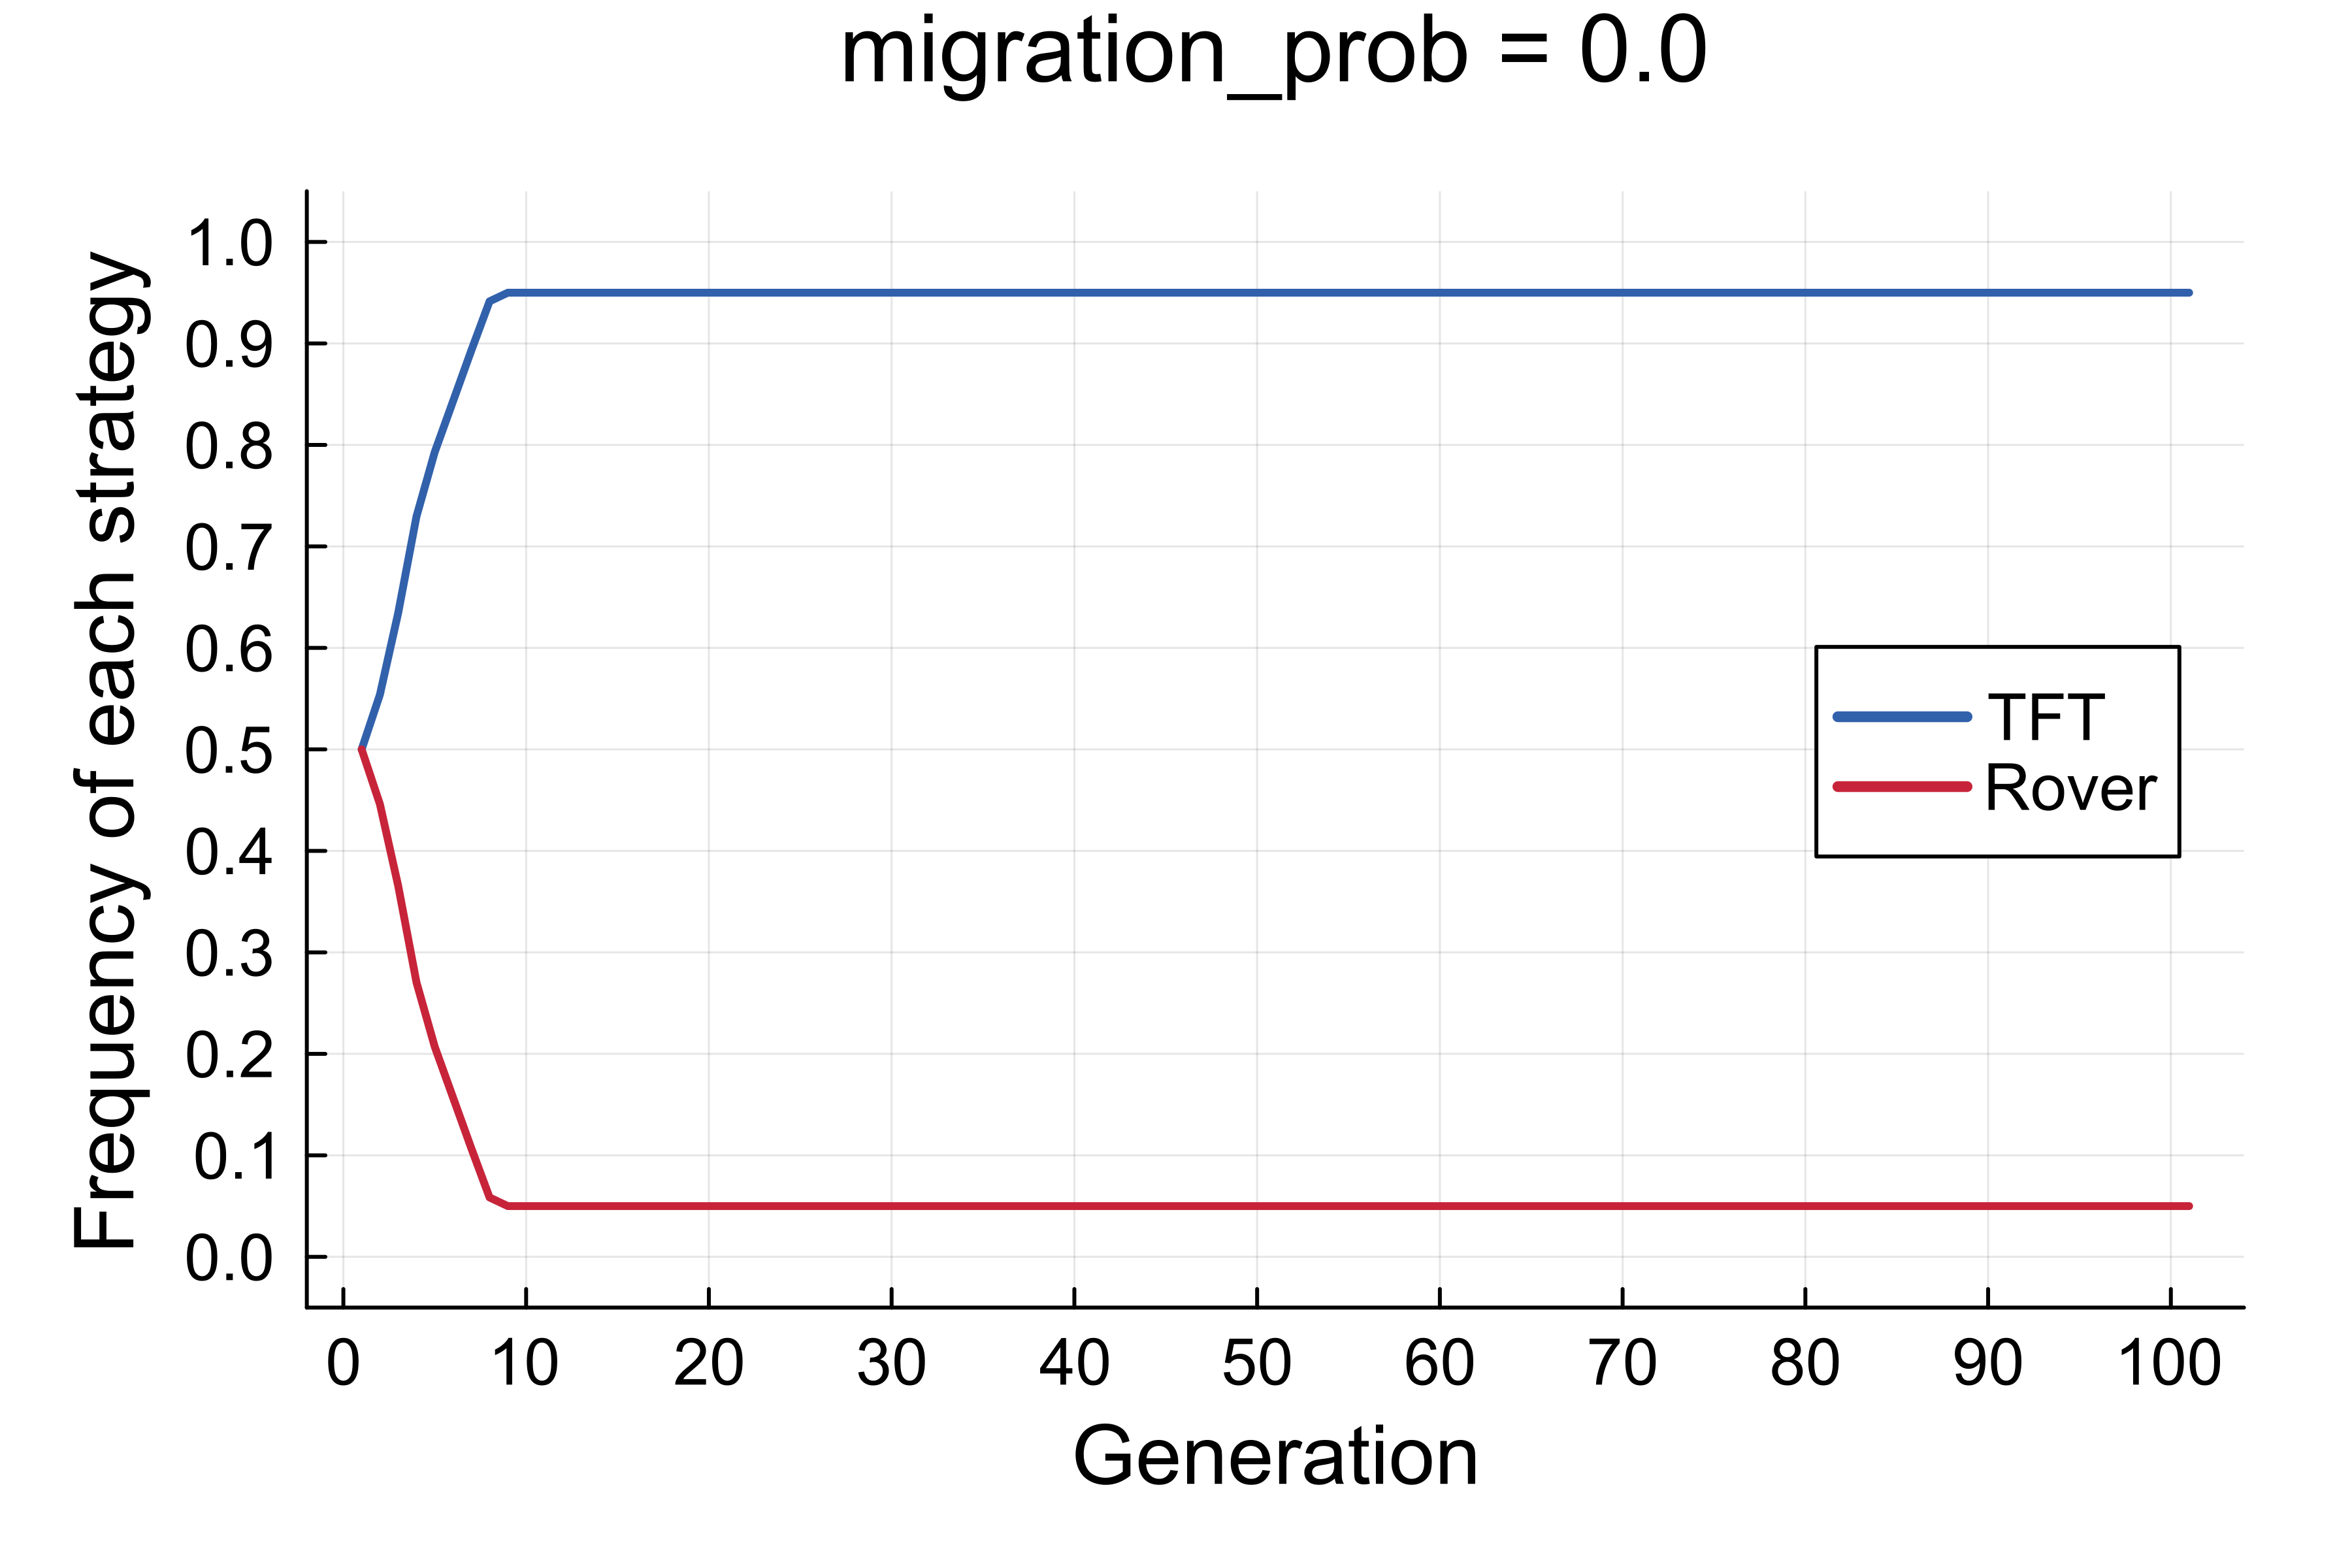

In [28]:
patches = make_patches(patch_num = 100, patch_size = 20, tft_rate = 0.5)
pop_transition_mat = run!(patches, migration_prob = 0.0, migration_cost = PAYOFF.T * 0.0)
plot_lines(pop_transition_mat, "migration_prob = 0.0")
# savefig("Fig2a.png")

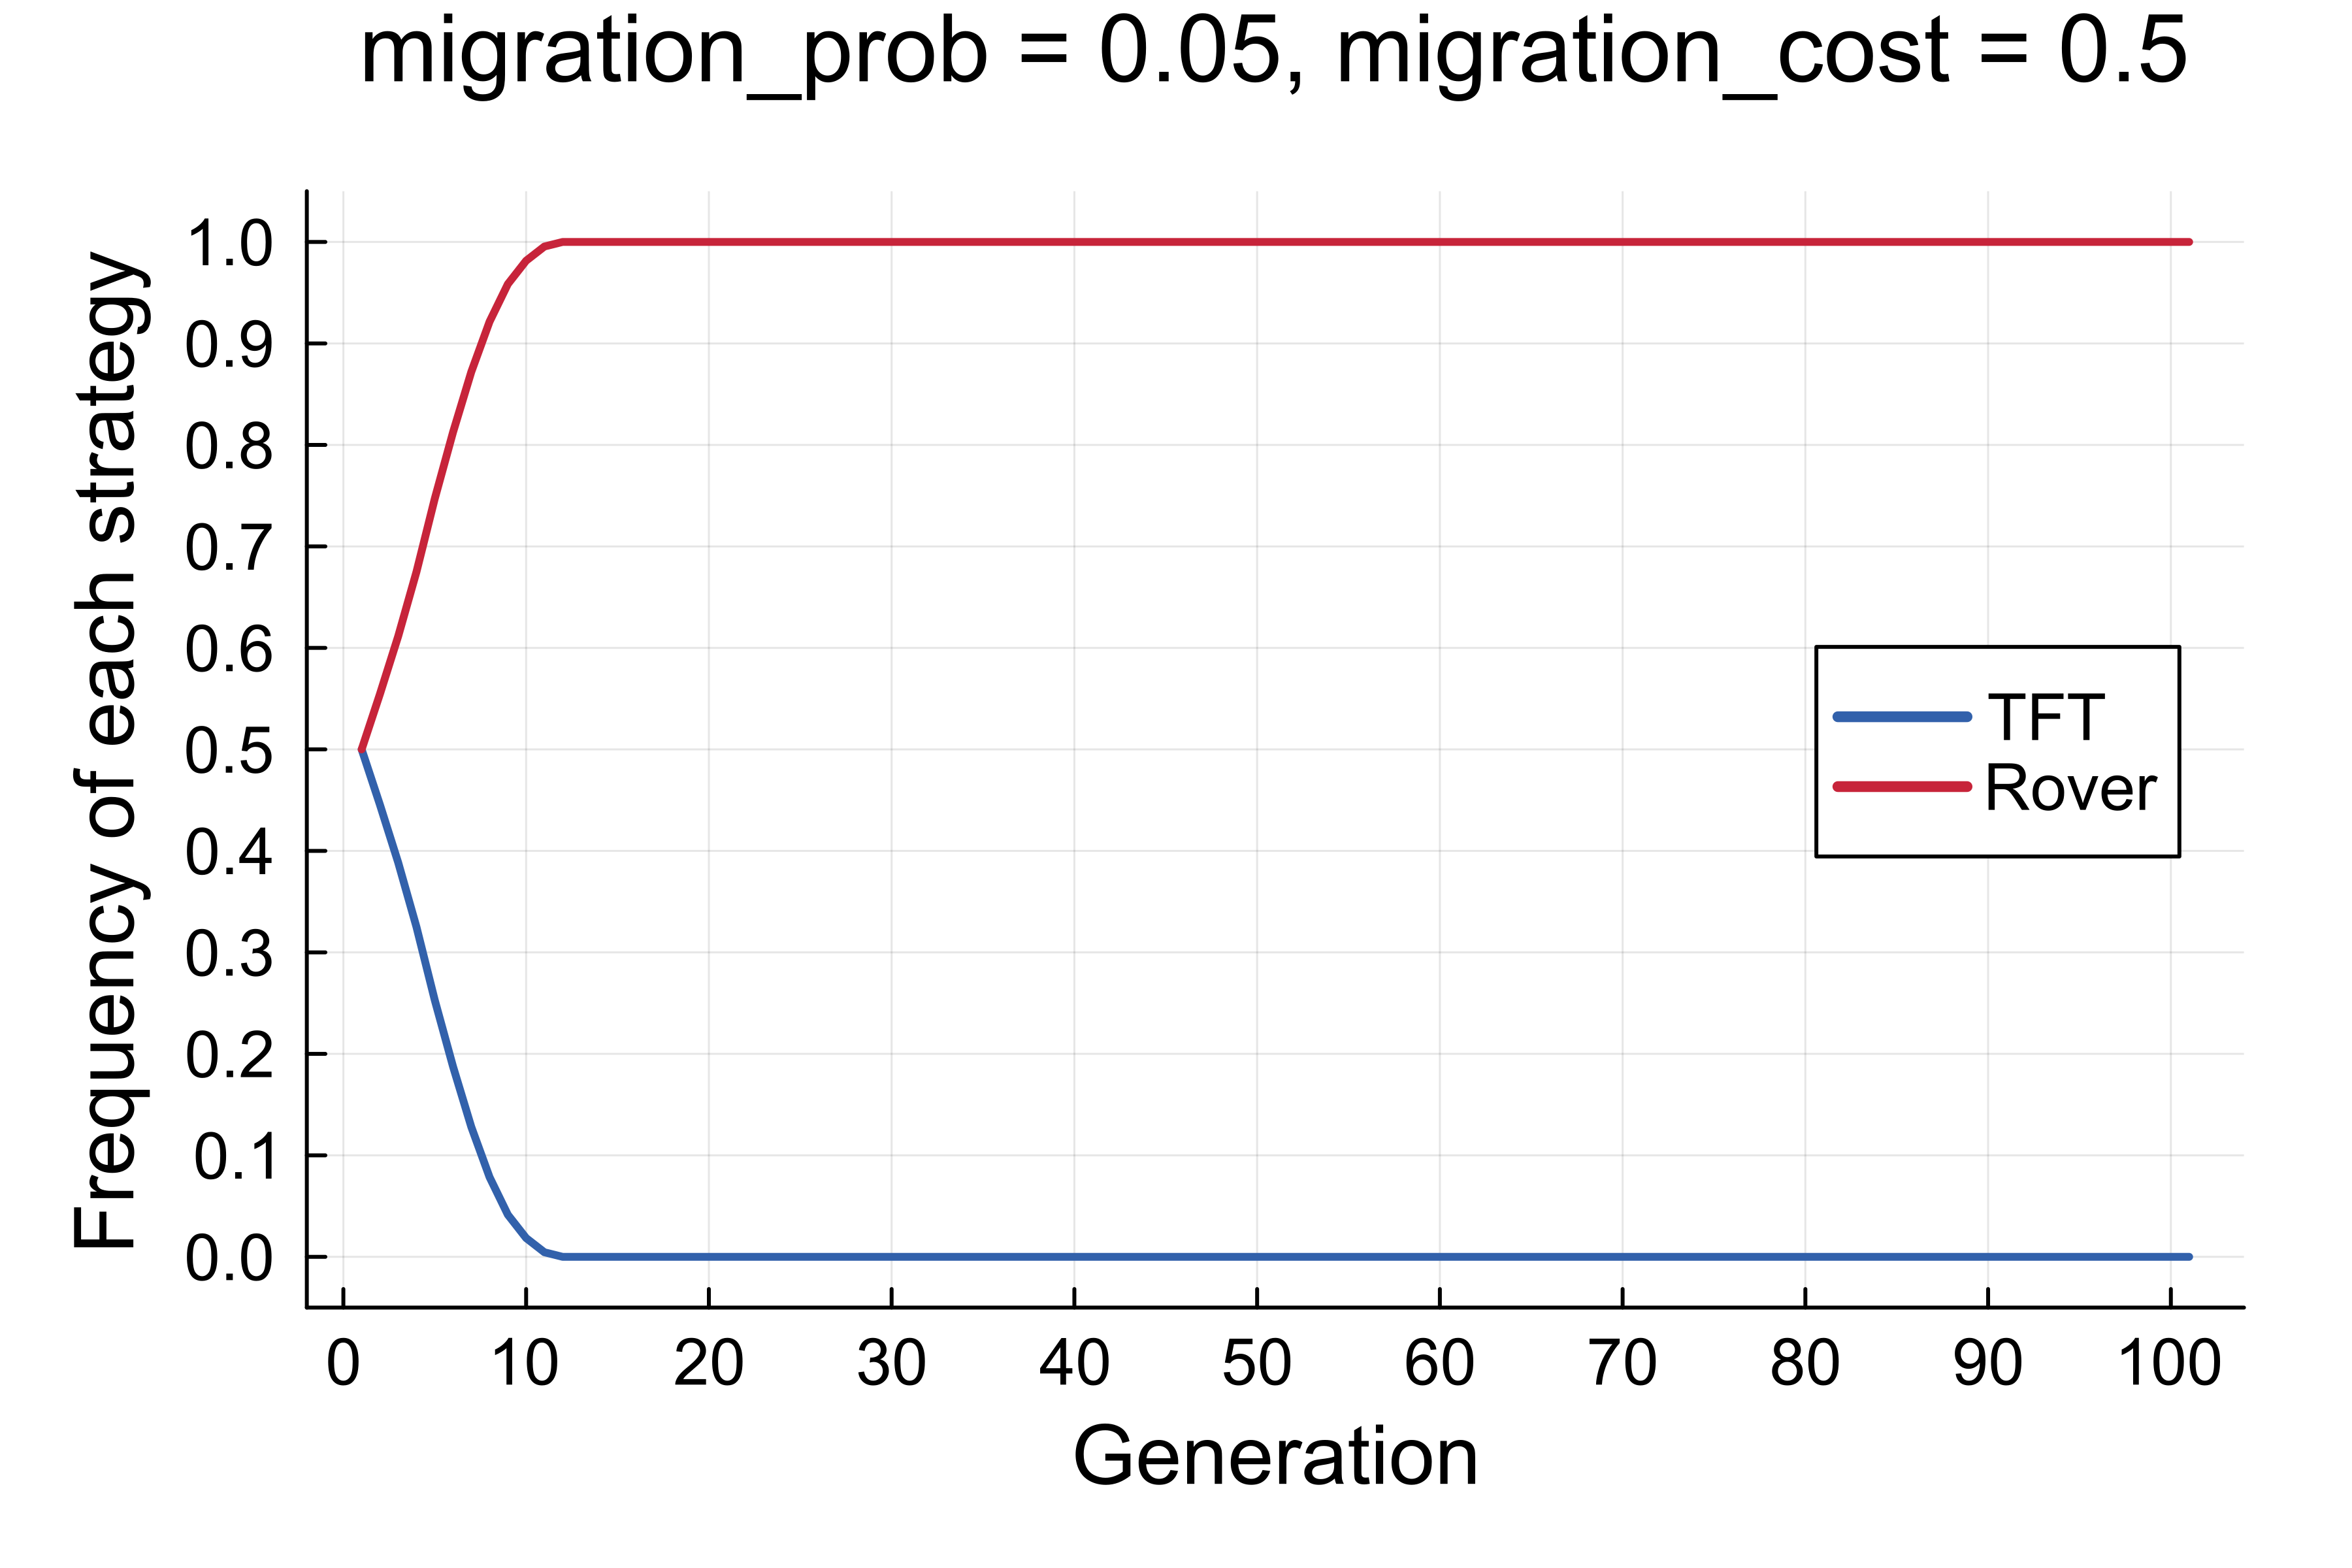

In [29]:
patches = make_patches(patch_num = 100, patch_size = 20, tft_rate = 0.5)
pop_transition_mat = run!(patches, migration_prob = 0.05, migration_cost = PAYOFF.T * 0.1)
plot_lines(pop_transition_mat, "migration_prob = 0.05, migration_cost = $(PAYOFF.T * 0.1)")
# savefig("Fig2b.png")

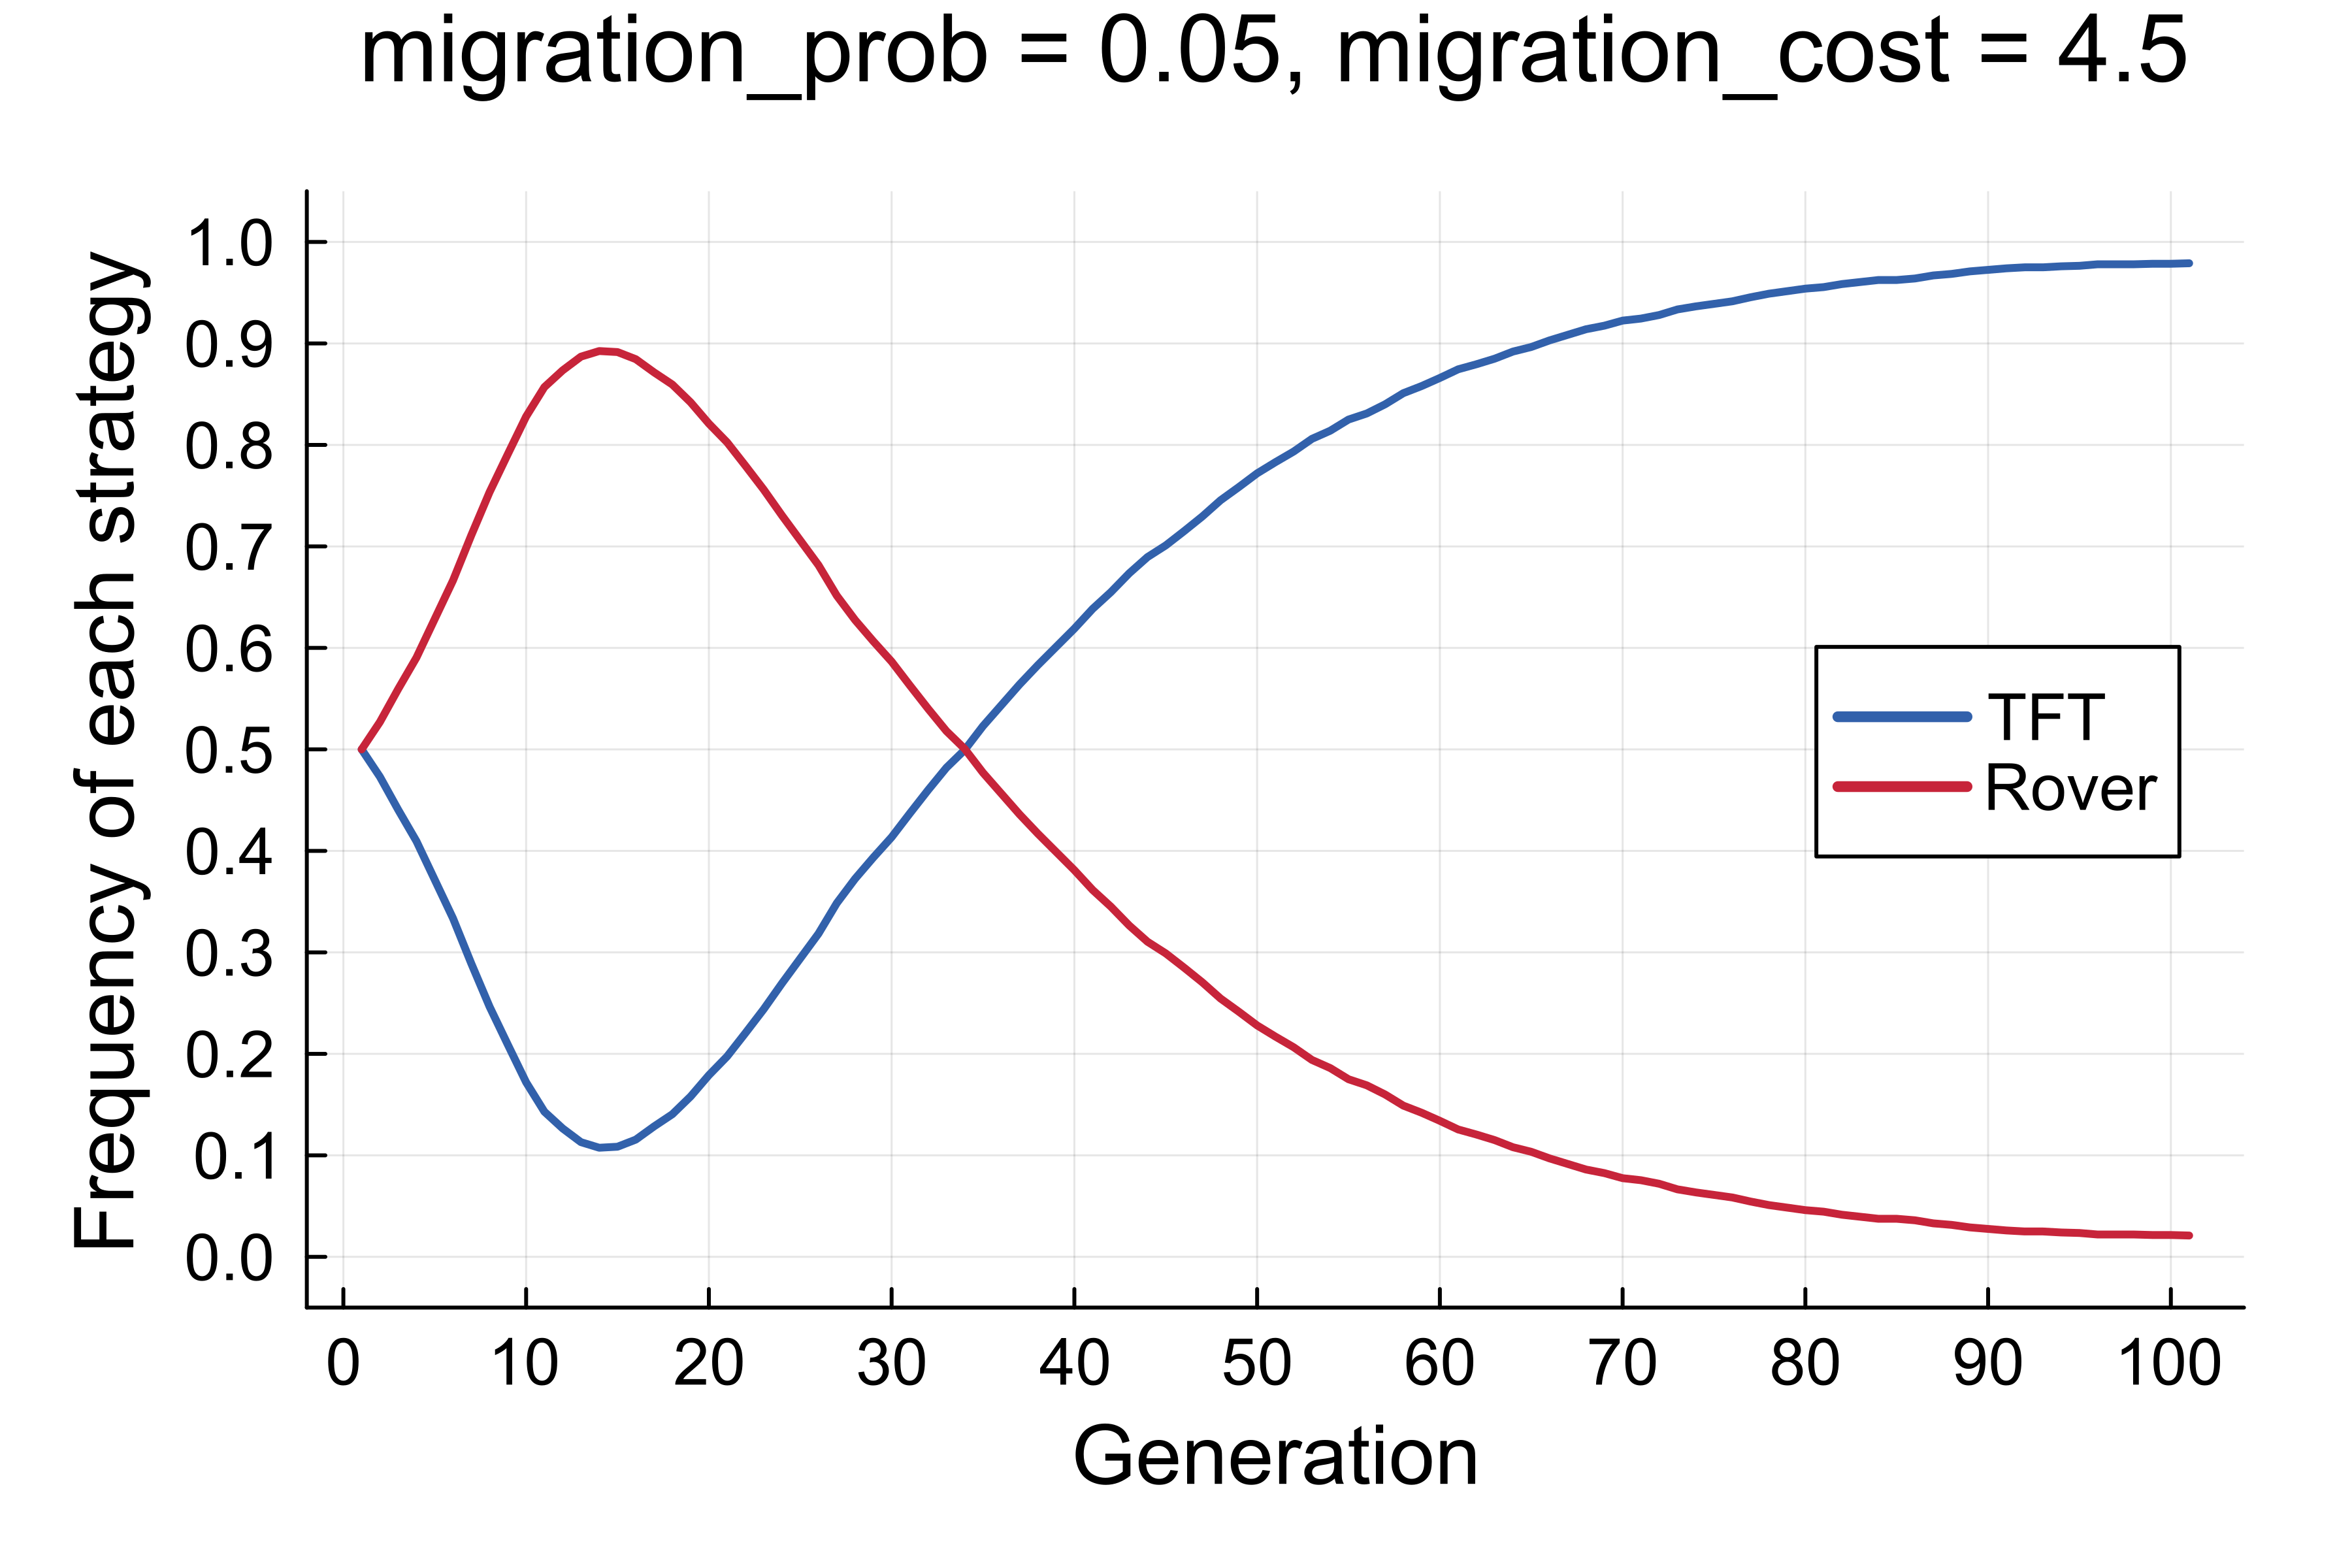

In [30]:
patches = make_patches(patch_num = 100, patch_size = 20, tft_rate = 0.5)
pop_transition_mat = run!(patches, migration_prob = 0.05, migration_cost = PAYOFF.T * 0.9)
plot_lines(pop_transition_mat, "migration_prob = 0.05, migration_cost = $(PAYOFF.T * 0.9)")
# savefig("Fig2c.png")